In [142]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage import feature
from scipy.stats import skew
from skimage import transform as trans
import pandas as pd
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from src.detectors import detect_face_mtcnn
from PIL import Image

In [74]:
def get_lbp(image, num_points, radius):
    lbp = feature.local_binary_pattern(image, num_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.flatten(), bins=np.arange(0, num_points + 3))
    return hist

def get_lbp_features(red_channel):
    lbp_features = np.array([])
    for i in range(3):
        for j in range(3):
            lbp_features = np.append(lbp_features, 
                                     get_lbp(red_channel[0 + 16*i: 32 + 16*i, 0 + 16*j: 32 + 16*j], 8, 1))
    lbp_features = np.append(lbp_features, get_lbp(red_channel, 8, 1))
    lbp_features = np.append(lbp_features, get_lbp(red_channel, 16, 2))
    return lbp_features

def get_R_devided_G_texture_features(R, G):
    lbp_r = np.array([])
    lbp_g = np.array([])
    for i in range(3):
        for j in range(3):
            lbp_r = np.append(lbp_r, 
                                     get_lbp(R[0 + 16*i: 32 + 16*i, 0 + 16*j: 32 + 16*j], 8, 1))
            lbp_g = np.append(lbp_g, 
                                     get_lbp(G[0 + 16*i: 32 + 16*i, 0 + 16*j: 32 + 16*j], 8, 1))
    return lbp_r - lbp_g

def get_statistical_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    features = np.array([])
    for i in range(2):
        for j in range(2):
            for c in range(3):
                mean = np.mean(image[0 + 32*i:32 + 32*i, 0 + 32*j:32 + 32*j, c])
                std = np.std(image[0 + 32*i:32 + 32*i, 0 + 32*j:32 + 32*j, c])
                features = np.append(features, [mean , std])
    return features

def get_all_fetures(image):
    features = np.array([])
    lbp = get_lbp_features(image[:, :, 0])
    features = np.append(features, lbp)
    R_G = get_R_devided_G_texture_features(image[:, :, 0], image[:, :, 1])
    features = np.append(features, R_G)
    stats = get_statistical_features(image)
    features = np.append(features, stats)
    return features

In [60]:
def transform(image, landmarks):
    src = np.array([
        [38.2946, 51.6963],
        [73.5318, 51.5014],
        [56.0252, 71.7366],
        [41.5493, 92.3655],
        [70.7299, 92.2041]], dtype=np.float32)
    dst = landmarks.reshape((2, 5)).T.astype(np.float32)
    tform = trans.SimilarityTransform()
    tform.estimate(dst, src)
    tform = tform.params[0:2, :]
    warped = cv2.warpAffine(image, tform, (112, 112), borderValue=0.0)
    return warped 

In [112]:
def read_file(file):
    with open('raw/' + file, 'r') as f:
        arr = []
        for line in f:
            path = line.replace('\\', '/')[:-1]
            arr.append(path)
    return arr

In [114]:
def make_features(client, imposter):
    client_path = 'raw/ClientRaw/'
    imposter_path = 'raw/ImposterRaw/'
    client_features = []
    for c in client:
        image = plt.imread(client_path + c)
        _, landmarks = detect_face_mtcnn(Image.fromarray(image))
        if landmarks is None:
            continue
        image = transform(image, landmarks)[20:, 15:97]
        image = cv2.resize(image, (64, 64))
        features = get_all_fetures(image)
        features = np.append(features, 0)
        client_features.append(features)
    
    imposter_features = []
    for i in imposter:
        image = plt.imread(imposter_path + i)
        _, landmarks = detect_face_mtcnn(Image.fromarray(image))
        if landmarks is None:
            continue
        image = transform(image, landmarks)[20:, 15:97]
        image = cv2.resize(image, (64, 64))
        features = get_all_fetures(image)
        features = np.append(features, 1)
        imposter_features.append(features)
        
    client_features = np.vstack(client_features)
    imposter_features = np.vstack(imposter_features)
    features = np.concatenate([client_features, imposter_features], axis = 0)
    return features

In [113]:
client_train = read_file('client_train_raw.txt')
imposter_train = read_file('imposter_train_raw.txt')
client_test = read_file('client_test_raw.txt')
imposter_test = read_file('imposter_test_raw.txt')

In [115]:
df = make_features(client_train, imposter_train)
X, y = df[:, :-1], df[:, -1]
np.save(file='train_features', arr=df)

df = make_features(client_test, imposter_test)
X_test, y_test = df[:, :-1], df[:, -1]
np.save(file='test_features', arr=df)

X, y = shuffle(X, y, random_state=42)

In [152]:
df = np.load('train_features.npy')
X, y = df[:, :-1], df[:, -1]

df = np.load('test_features.npy')
X_test, y_test = df[:, :-1], df[:, -1]

X, y = shuffle(X, y, random_state=42)
sscaler = StandardScaler()
sscaler.fit(X)
X = sscaler.transform(X)

In [159]:
parameters = {
    'kernel':('linear', 'rbf'), 
    'C':range(1, 3),
    'gamma':('scale', 'auto'),
}
svc = SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
clf.fit(X, y)
clf.best_params_

{'C': 1, 'cache_size': 1, 'gamma': 'scale', 'kernel': 'rbf'}

In [160]:
f1_score(y_test, clf.predict(X_test))

0.7740591397849462

In [161]:
accuracy_score(y_test, clf.predict(X_test))

0.6314000657822607

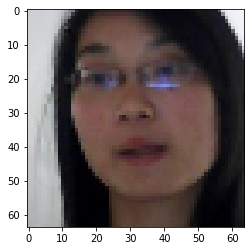

In [107]:
client_path = 'Detectedface/ClientFace/'
imposter_path = 'Detectedface/ImposterFace/'
client_features = []
image = plt.imread(client_path + client_train[300])
image = cv2.resize(image, (64, 64))
plt.imshow(image)

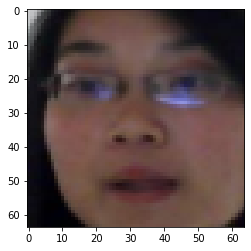

In [108]:
client_path = 'raw/ClientRaw/'
imposter_path = 'raw/ImposterRaw/'
client_features = []
image = plt.imread(client_path + client_train[300])
_, landmarks = detect_face_mtcnn(Image.fromarray(image))
image = transform(image, landmarks)[20:, 15:97]
image = cv2.resize(image, (64, 64))
plt.imshow(image)

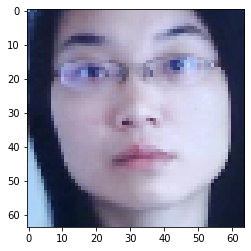

In [109]:
client_path = 'Detectedface/ClientFace/'
imposter_path = 'Detectedface/ImposterFace/'
client_features = []
image = plt.imread(imposter_path + imposter_train[300])
image = cv2.resize(image, (64, 64))
plt.imshow(image)

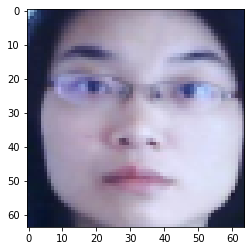

In [110]:
client_path = 'raw/ClientRaw/'
imposter_path = 'raw/ImposterRaw/'
client_features = []
image = plt.imread(imposter_path + imposter_train[300])
_, landmarks = detect_face_mtcnn(Image.fromarray(image))
image = transform(image, landmarks)[20:, 15:97]
image = cv2.resize(image, (64, 64))
plt.imshow(image)